##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

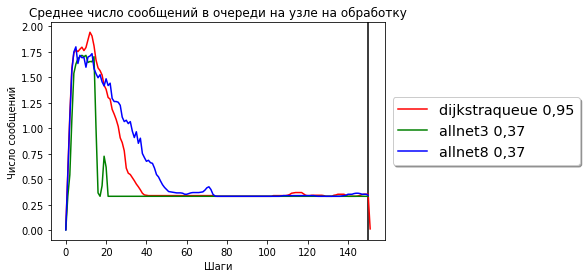

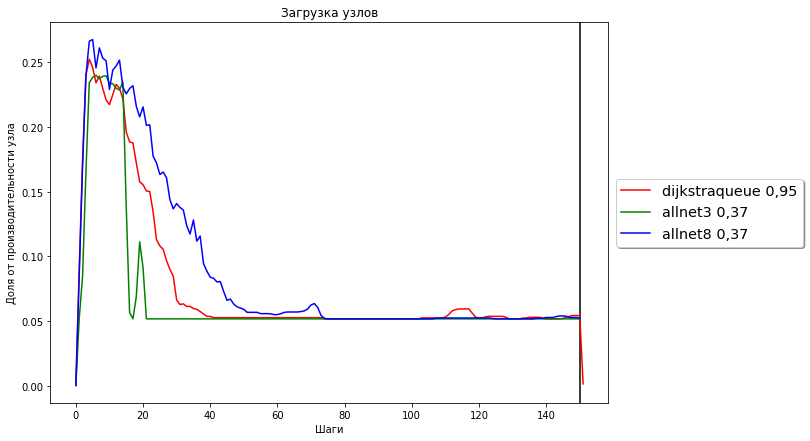

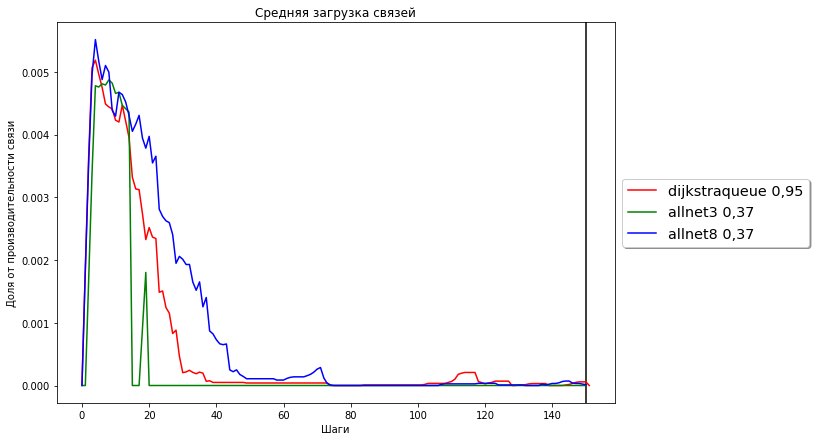

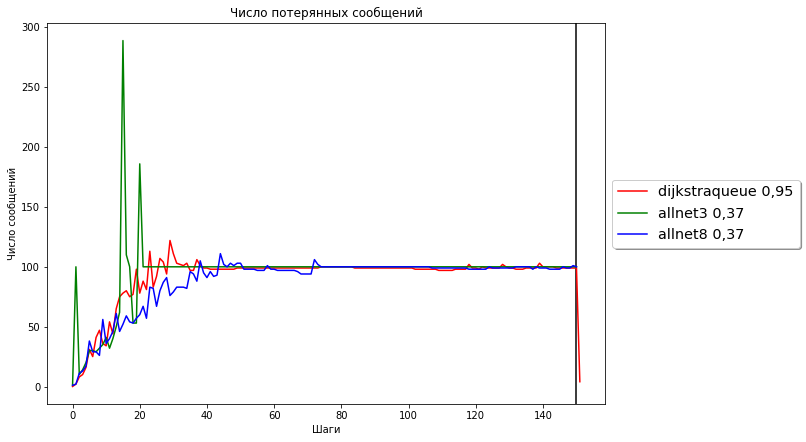

Доставлено 1137 Потеряно 92.4205% -dijkstraqueue 0,95
Доставлено 684 Потеряно 95.4403% -allnet3 0,37
Доставлено 1644 Потеряно 89.0407% -allnet8 0,37


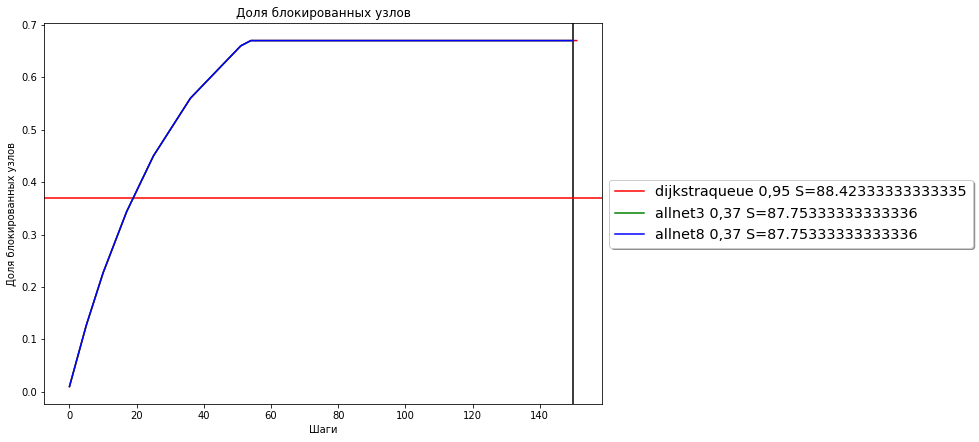

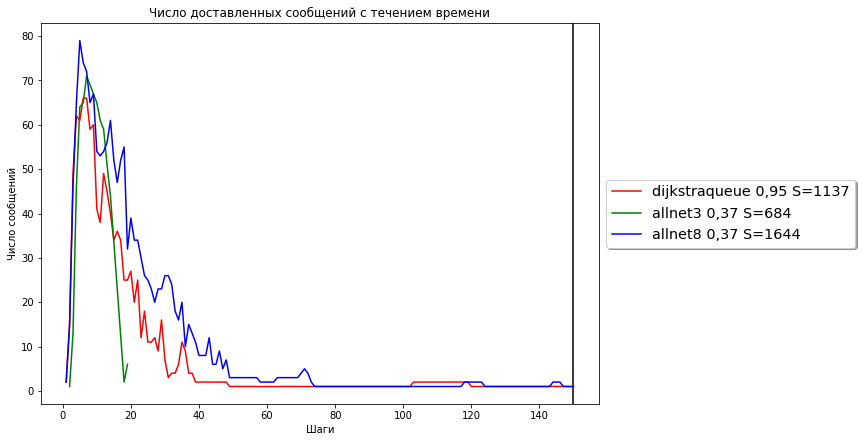

In [2]:
quantity = 100;
log_tags = [
{"tag":  "fd988d0d-cf3d-4f1c-8ff9-1e0c5500f2a8", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "26ca1232-47bd-4e9b-8bd0-134f59079f43", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6b36df0e-5fa6-4f82-81f6-1713f45a288f", "label": "allnet8 0,37", "color": "blue"},

]                         
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

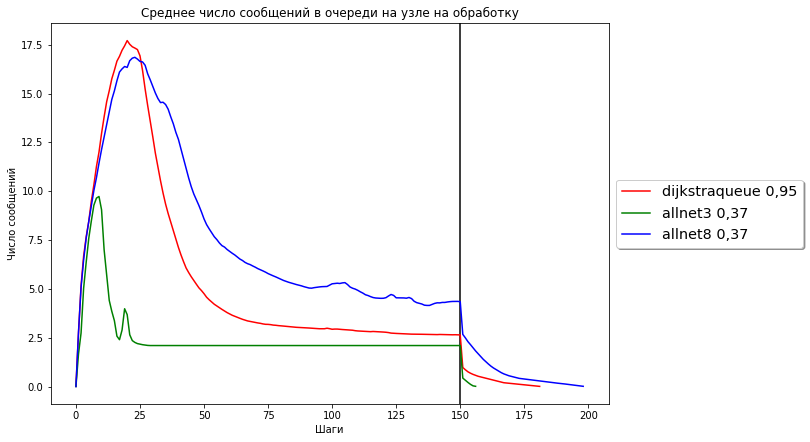

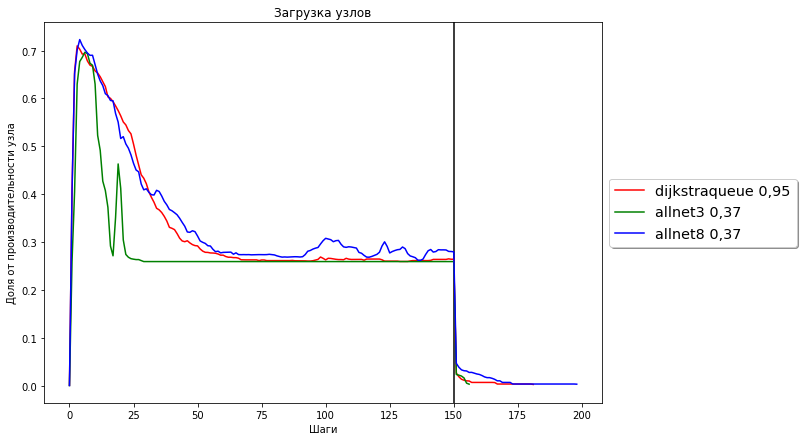

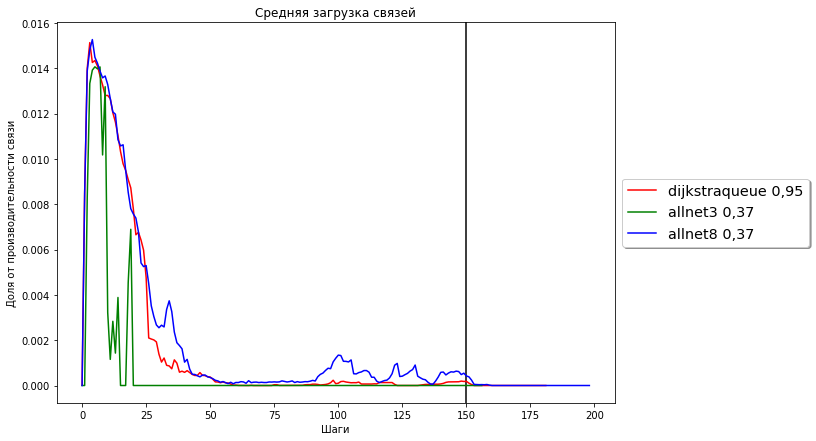

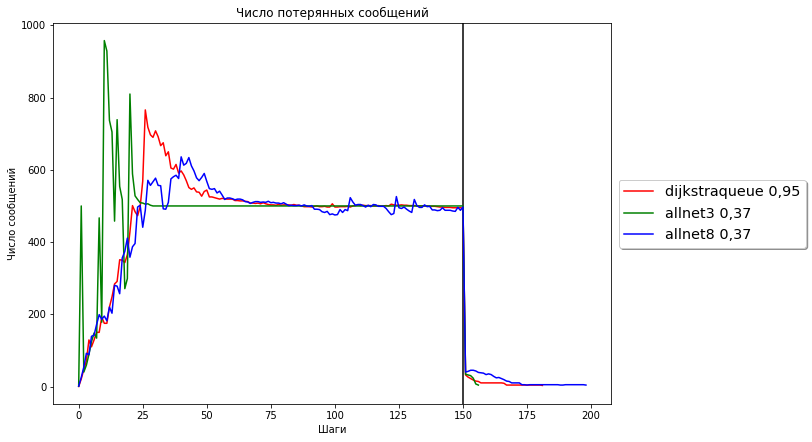

Доставлено 2222 Потеряно 97.0374% -dijkstraqueue 0,95
Доставлено 988 Потеряно 98.6827% -allnet3 0,37
Доставлено 3370 Потеряно 95.5067% -allnet8 0,37


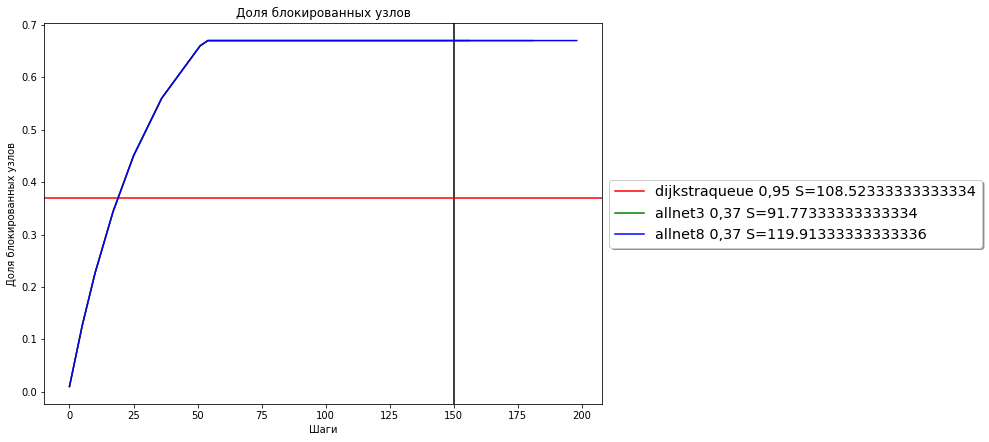

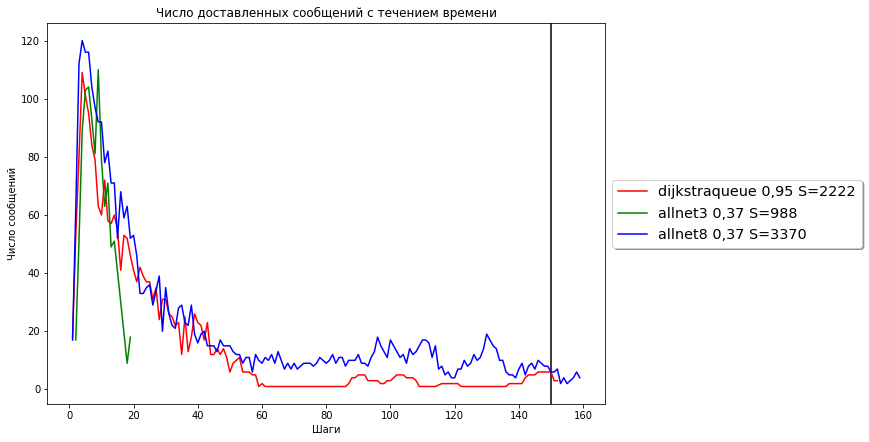

In [3]:
quantity = 500;
log_tags = [
{"tag":  "883f5741-ee0b-4ff8-a1e4-213e06fc4232", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e9797cd9-57a3-4bb1-8b33-e72b94a2564c", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ed80fe31-d407-4c7d-883b-6fab9018668f", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

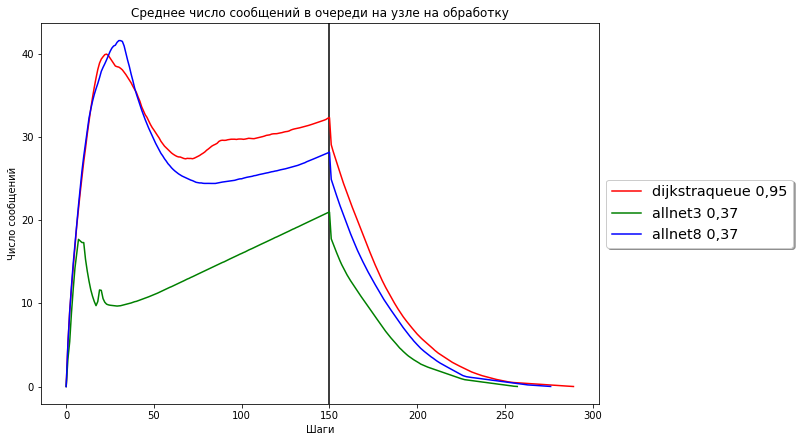

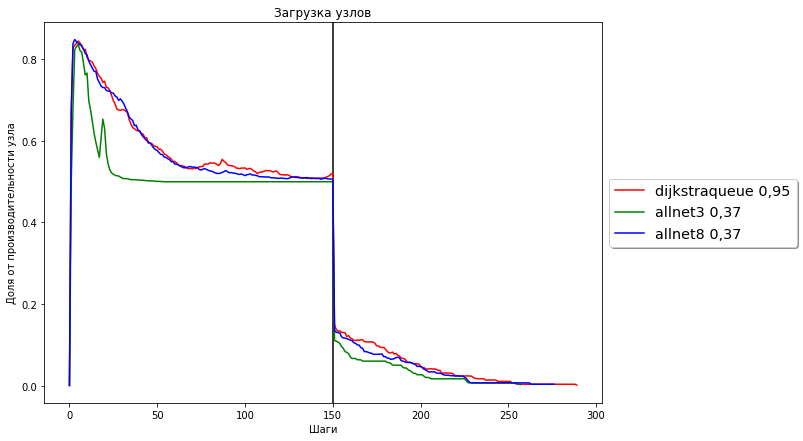

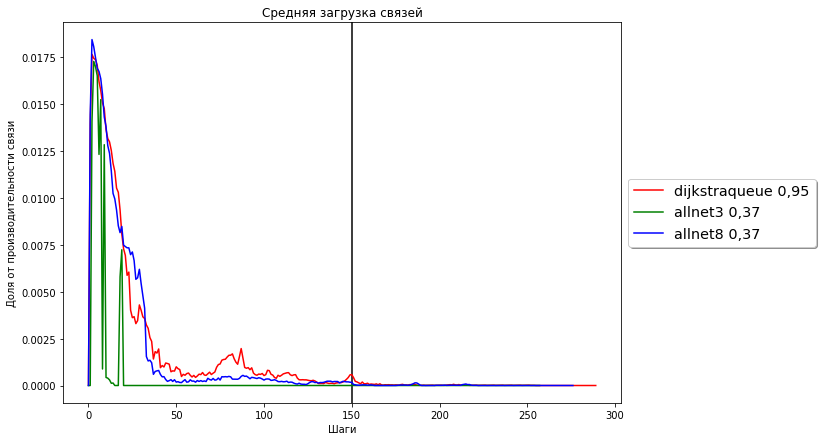

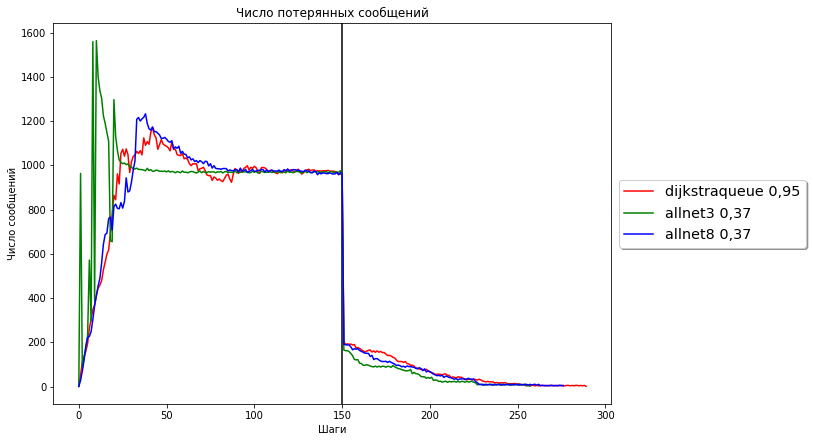

Доставлено 2900 Потеряно 98.0667% -dijkstraqueue 0,95
Доставлено 543 Потеряно 99.6380% -allnet3 0,37
Доставлено 2949 Потеряно 98.0340% -allnet8 0,37


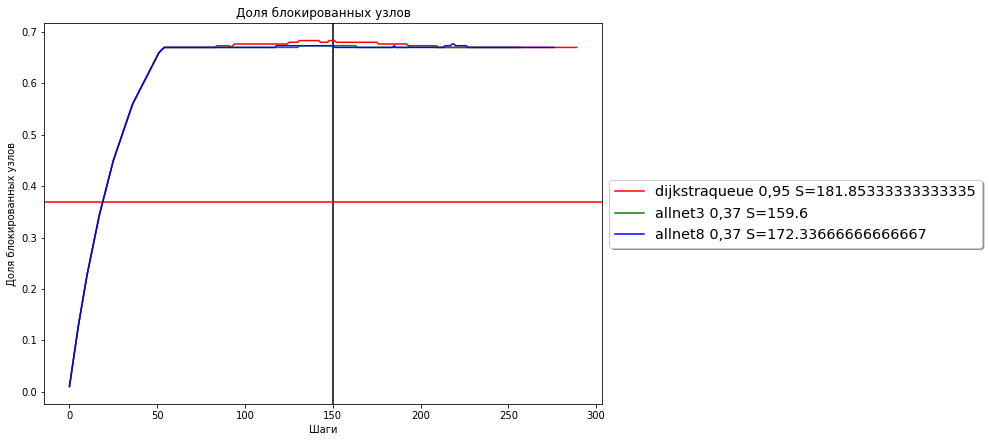

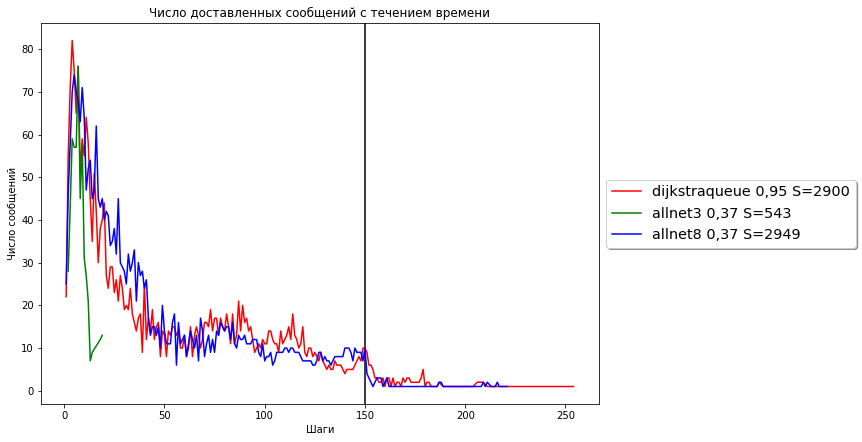

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "fa04f21a-5737-4d75-b4a0-544430a71bc9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "623d1b60-8c60-41d3-b757-7b0edf649bb6", "label": "allnet3 0,37", "color": "green"},
{"tag":  "c77a5eb2-decc-41d3-9221-047613d184b4", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

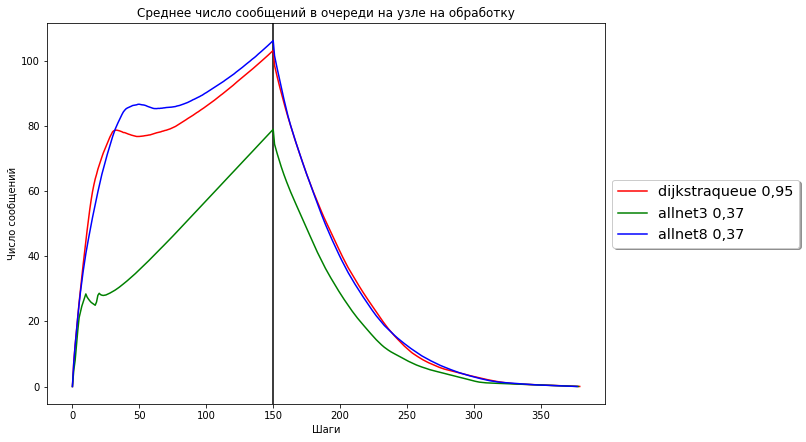

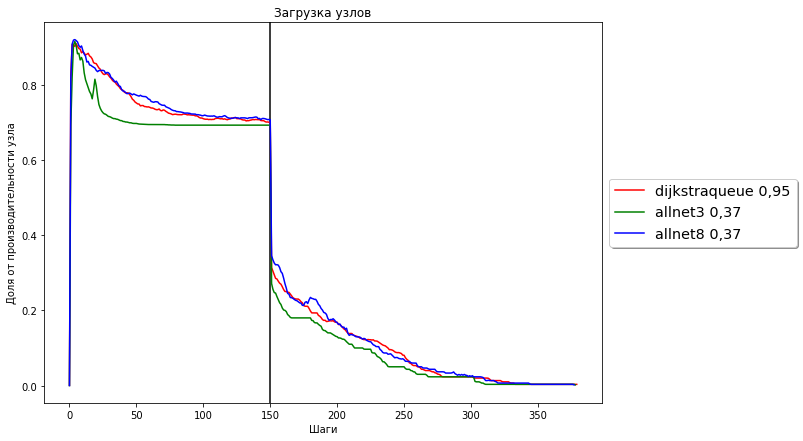

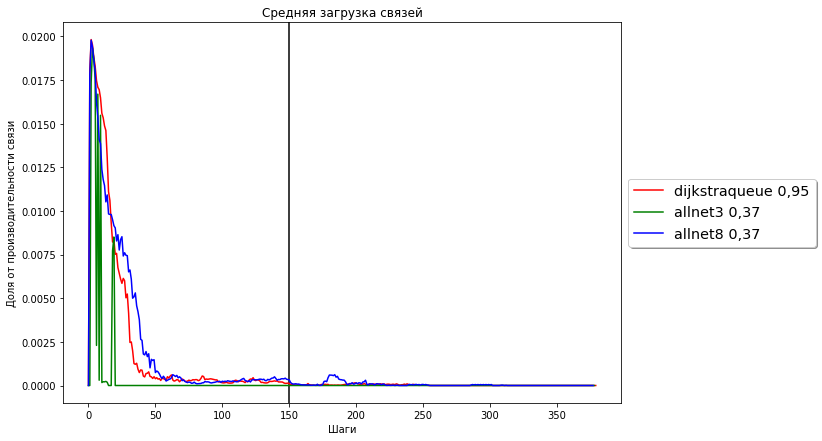

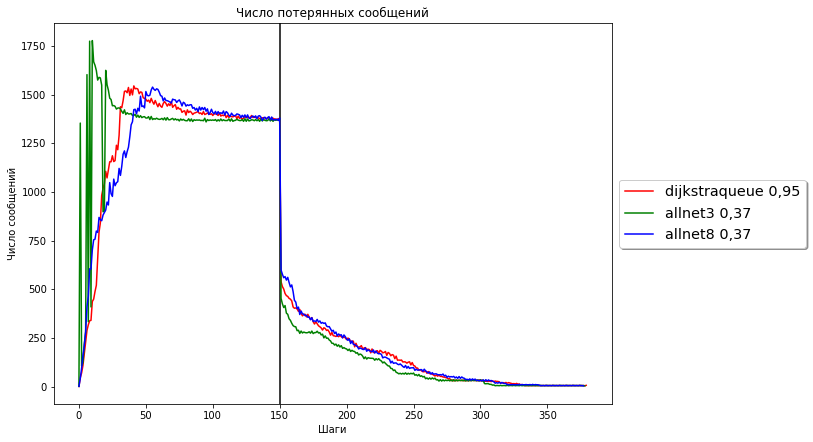

Доставлено 2971 Потеряно 98.6796% -dijkstraqueue 0,95
Доставлено 395 Потеряно 99.8244% -allnet3 0,37
Доставлено 3559 Потеряно 98.4182% -allnet8 0,37


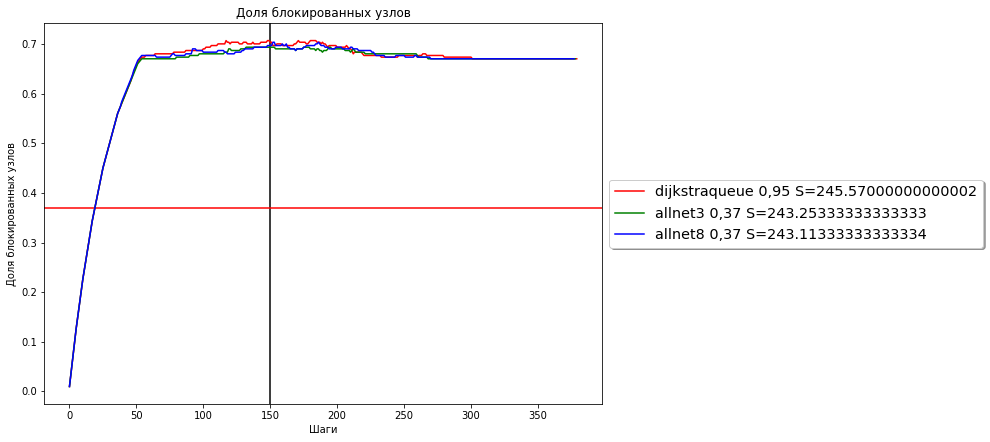

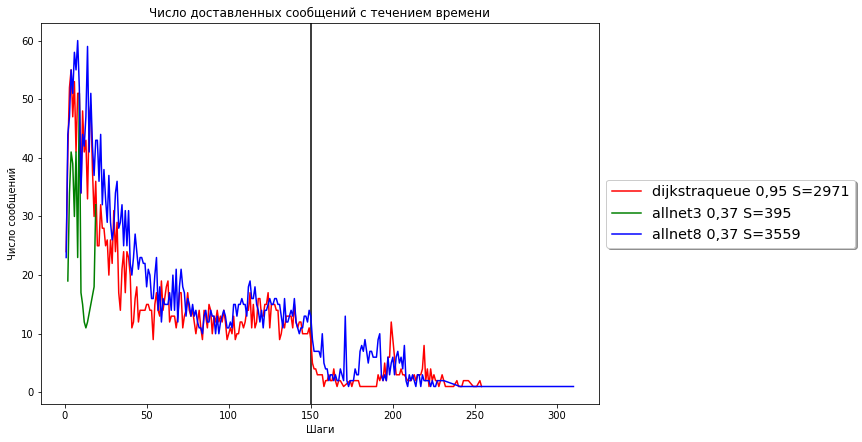

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "0b1355f1-5d86-4807-9b16-2a53bc0abd08", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8e63245e-c6c1-4a41-bc10-57c4e3217a4e", "label": "allnet3 0,37", "color": "green"},
{"tag":  "3b4fef1b-d91c-4d4b-8e26-c08e5b13565c", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 2825 Потеряно 93.7224% -dijkstraqueue 0,95
Доставлено 892 Потеряно 98.0178% -allnet3 0,37
Доставлено 2470 Потеряно 94.5112% -allnet8 0,37


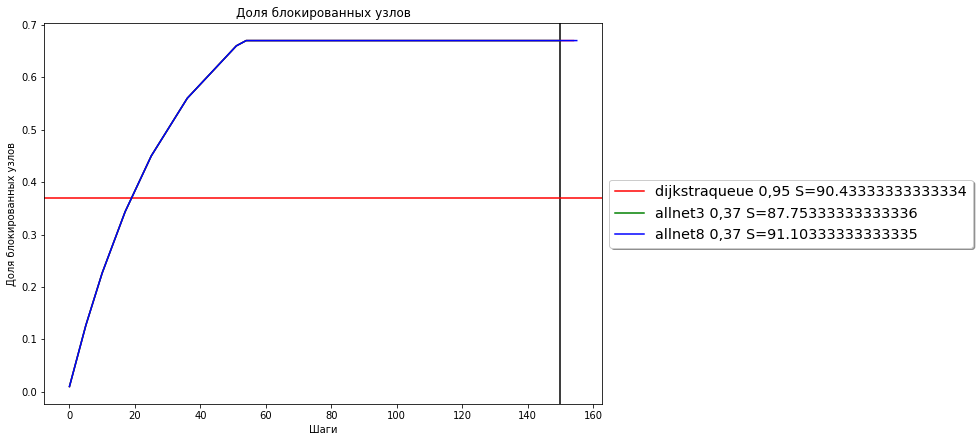

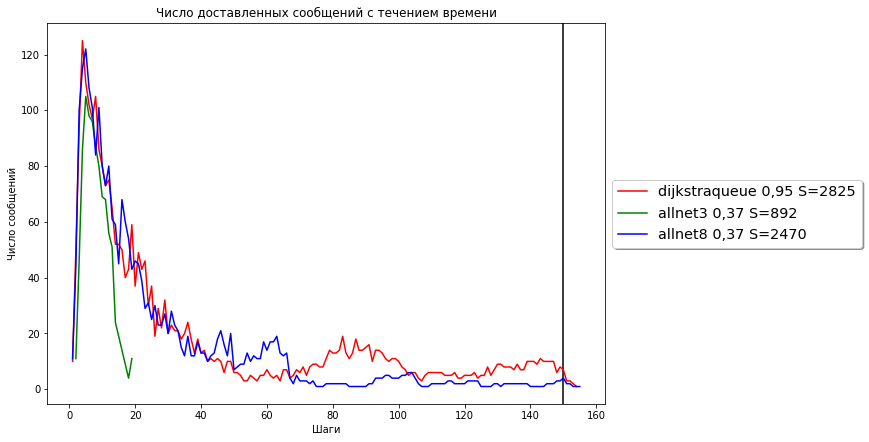

Доставлено 3155 Потеряно 96.9953% -dijkstraqueue 0,95
Доставлено 827 Потеряно 99.2124% -allnet3 0,37
Доставлено 2802 Потеряно 97.3315% -allnet8 0,37


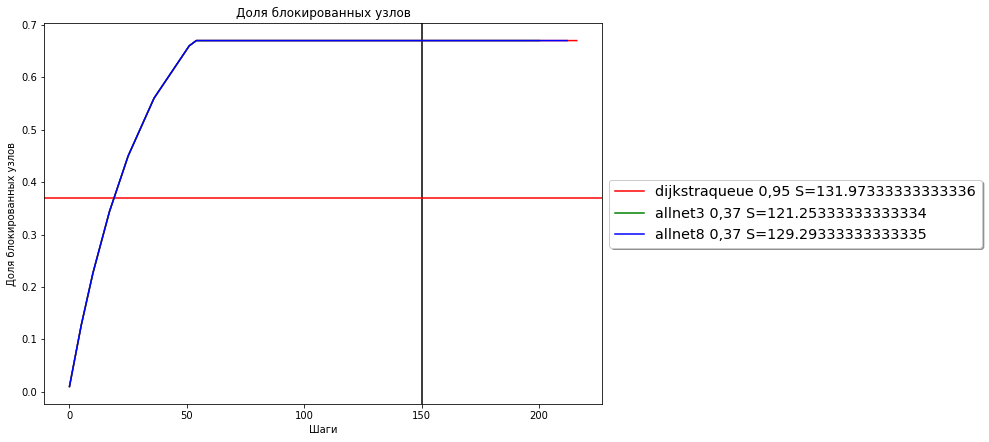

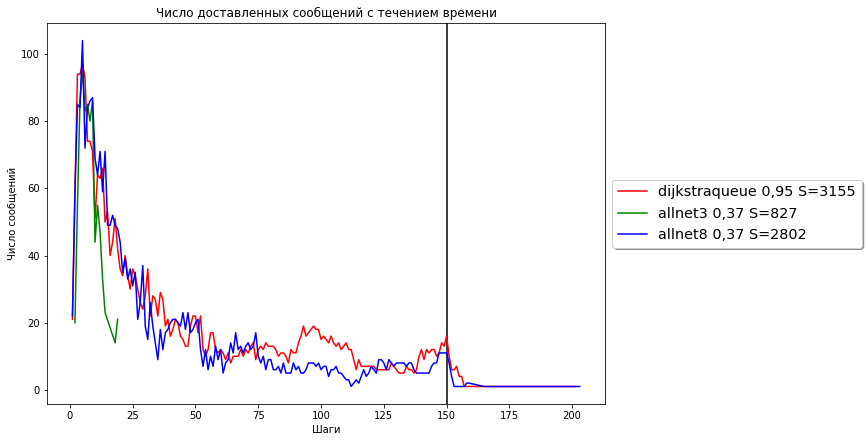

Доставлено 3113 Потеряно 97.6941% -dijkstraqueue 0,95
Доставлено 618 Потеряно 99.5422% -allnet3 0,37
Доставлено 3284 Потеряно 97.5674% -allnet8 0,37


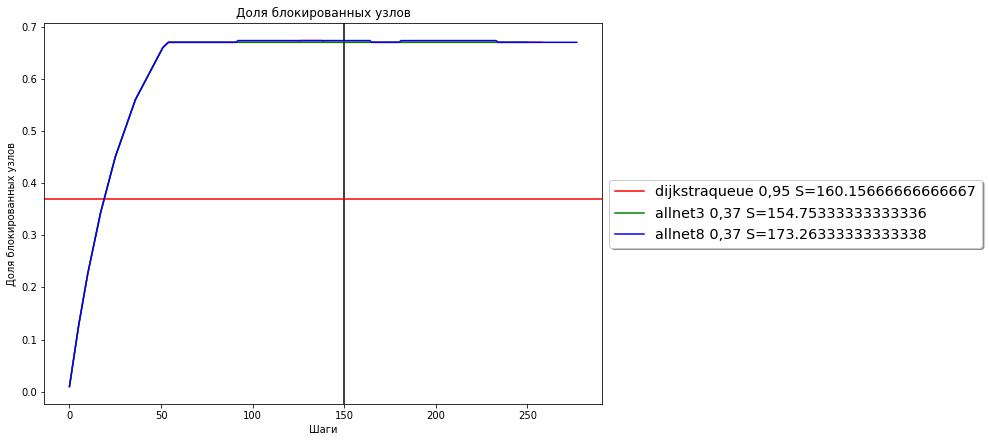

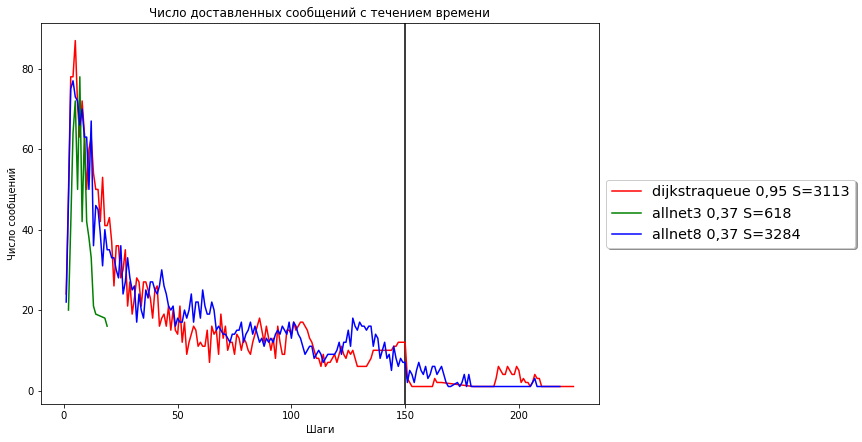

Доставлено 3128 Потеряно 98.3959% -dijkstraqueue 0,95
Доставлено 395 Потеряно 99.7974% -allnet3 0,37
Доставлено 3004 Потеряно 98.4595% -allnet8 0,37


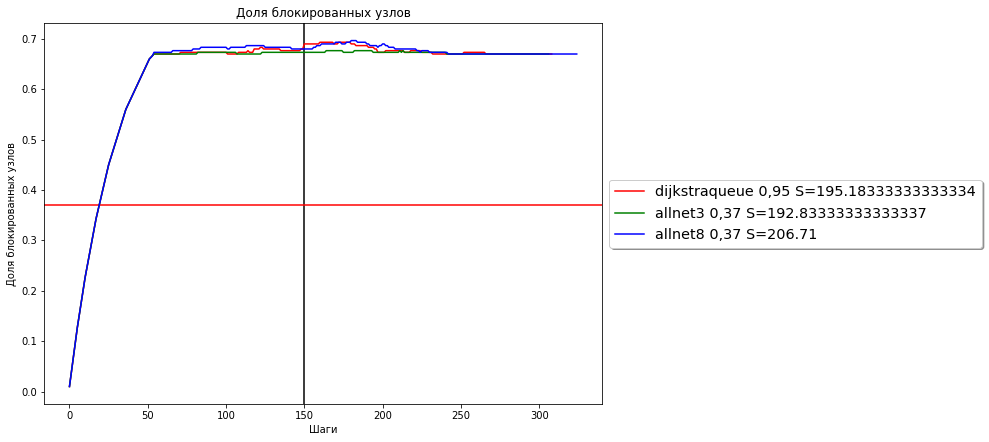

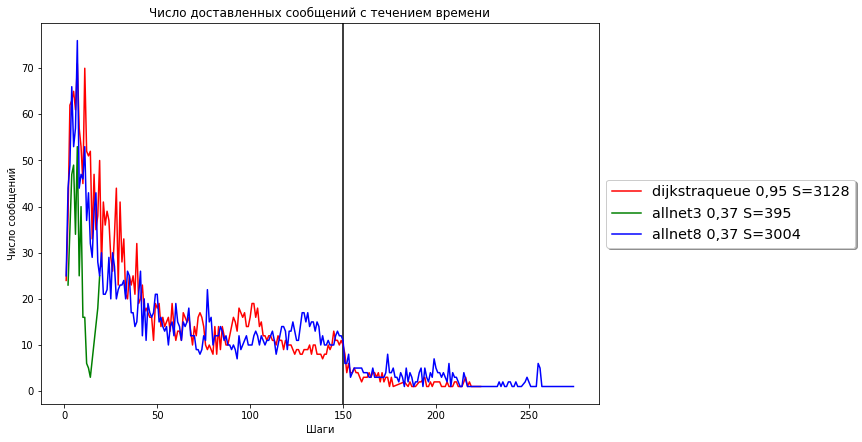

In [6]:
quantity = 300;
log_tags = [
{"tag":  "85a23f7b-c338-48ef-8721-642d622e9c1d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b3ea7384-0040-4832-a922-861f8760fd35", "label": "allnet3 0,37", "color": "green"},
{"tag":  "57e05885-2c8c-43e6-af34-49c4ebc3ffe6", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "e28936c1-0dd3-45cc-8338-4aacc0fe9e2d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "58cebddb-2f43-404b-bf4d-7980fbfc34ac", "label": "allnet3 0,37", "color": "green"},
{"tag":  "47f92be5-8ab4-4983-86f4-bf39b9d887a2", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "394aaf0c-ae91-40e0-bada-a58c5aeeaa06", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "782511c8-9315-4c4a-9b0d-26802ab8f9b1", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8cc34836-410d-49d3-8300-81bfa3a013d4", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "9464b054-730f-4af0-a650-4fb3ff5224ea", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "14c191e5-52cb-4b23-beea-7eda657e5ed6", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6a354b7b-4ba0-43bf-bbcb-b779ea14c9d7", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

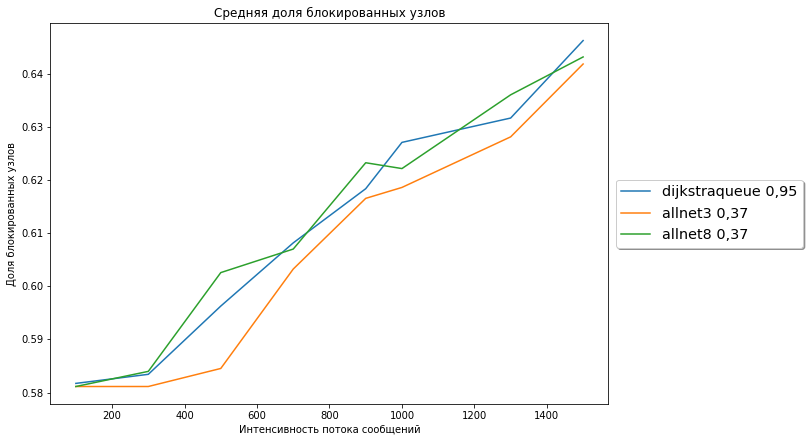

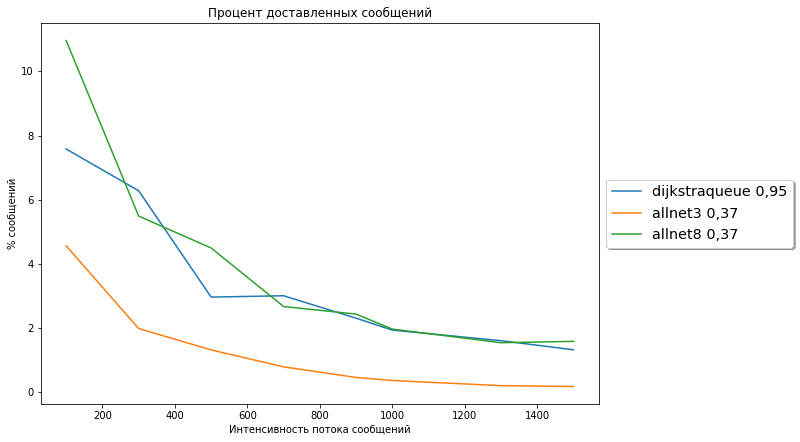

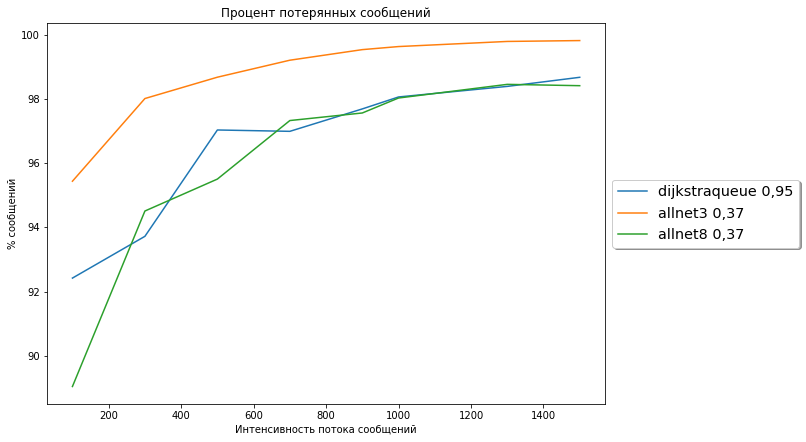

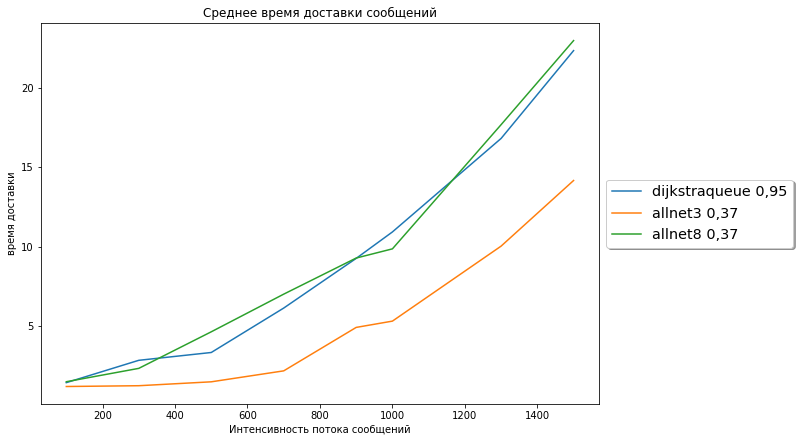

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.611621
allnet3 0,37          0.606899
allnet8 0,37          0.612416

dijkstraqueue 0,95    96.626468
allnet3 0,37          98.769414
allnet8 0,37          96.108663

dijkstraqueue 0,95    9.131183
allnet3 0,37          5.054001
allnet8 0,37          9.404712
